In [2]:
import os
from os.path import dirname
import numpy as np
from scipy.signal import find_peaks
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

sns.set(color_codes=True, style="white")
pd.options.mode.chained_assignment = None  # default='warn'

postfix = "FL_alone.png"

folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig2_diffusion analysis/fractions_FL_alone"
os.chdir(folder_save)
fname = "SPT_results_AIO_concat-0Dex_noTR_0hr.csv"
df = pd.read_csv(fname)

### Stacked bar plot of fractions

#### Calculations

In [3]:
# Displacement threshold for immobile molecules
immobile_stepsize_threshold_nm = 30
# alpha component threshold for constrained diffusion
threshold_alpha = 0.5
# Output file structure
columns = [
    "replicate_prefix",
    "N, Total",
    "N, Mobile",
    "N, Constrained",
    "Static Fraction",
    "Constrained Fraction",
]

In [5]:
lst_rows_of_df = []
df_current = df.astype(
    {"linear_fit_log10D": float, "mean_stepsize_nm": float, "alpha": float}
)
# all filenames within the current condition/file
all_filenames = df_current["filename"].unique().tolist()
# filename prefix for each replicate
replicate_prefixs = np.unique([f.split("FOV")[0] for f in all_filenames])

for prefix in replicate_prefixs:
    current_replicate_filenames = [f for f in all_filenames if prefix in f]
    df_current_replicate = df_current[
        df_current["filename"].isin(current_replicate_filenames)
    ]

    # Judege if immobile by mean step size
    df_mobile = df_current_replicate[
        df_current_replicate["mean_stepsize_nm"] >= immobile_stepsize_threshold_nm
    ]

    # Judge if constrained by alpha component
    df_constrained = df_mobile[df_mobile["alpha"] <= threshold_alpha]

    N_total = df_current_replicate.shape[0]
    N_mobile = df_mobile.shape[0]
    N_constrained = df_constrained.shape[0]

    if N_constrained < 1:
        continue

    F_immobile = (N_total - N_mobile) / N_total
    F_constrained = N_constrained / N_mobile

    # save
    lst_rows_of_df.append(
        [
            prefix,
            N_total,
            N_mobile,
            N_constrained,
            F_immobile,
            F_constrained,
        ]
    )

data = pd.DataFrame.from_records(
lst_rows_of_df,
columns=columns,
)

In [10]:
N_total = data["N, Total"].to_numpy(int)
N_mobile = data["N, Mobile"].to_numpy(int)
N_immobile = N_total - N_mobile
N_constrained = data["N, Constrained"].to_numpy(int)
N_normal = N_mobile - N_constrained

frac_immobile = N_immobile / N_total
frac_constrained = N_constrained / N_total
frac_normal = N_normal / N_total

data["Immobile"] = frac_immobile
data["Constrained"] = frac_constrained
data["Normal"] = frac_normal

F_immobile_mean = data["Immobile"].mean()
F_immobile_sem=data["Immobile"].sem()
F_constrained_mean=data["Constrained"].mean()
F_constrained_sem=data["Constrained"].sem()
F_normal_mean=data["Normal"].mean()
F_normal_sem=data["Normal"].sem()

#### Plot

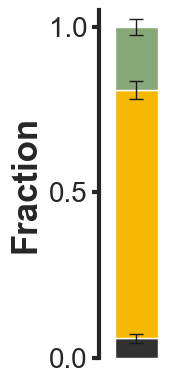

In [35]:
fig = plt.figure(figsize=(2, 4))
x = [1]
colors = [
    "#333232",
    "#f7b801",
    "#87a878",
]

bottom = np.zeros(len(x))
plt.bar(
    x=0,
    height=F_immobile_mean,
    yerr=F_immobile_sem,
    error_kw={"elinewidth": 1},
    capsize=5,
    bottom=0,
    color=colors[0],
)
plt.bar(
    x=0,
    height=F_constrained_mean,
    yerr=F_constrained_sem,
    error_kw={"elinewidth": 1},
    capsize=5,
    bottom=F_immobile_mean,
    color=colors[1],
)
plt.bar(
    x=0,
    height=F_normal_mean,
    yerr=F_normal_sem,
    error_kw={"elinewidth": 1},
    capsize=5,
    bottom=F_immobile_mean+F_constrained_mean,
    color=colors[2],
)
plt.ylim(0, 1.05)
plt.ylabel("Fraction", weight="bold", size=25)
plt.xticks([])
plt.yticks([0, 0.5, 1], size=15)
plt.gca().spines[:].set_linewidth(3)
plt.gca().spines[['right', 'top', 'bottom']].set_visible(False)
plt.gca().tick_params(
    axis="y",
    which="major",
    labelsize=20,
    direction="out",
    bottom=True,
    left=True,
    length=5,
    width=3,
)
canvas_width = 0.7
plt.xlim(-canvas_width,canvas_width)
plt.xlabel("")
plt.tight_layout()
plt.savefig("Fracs_FL_alone.png", format="png", bbox_inches="tight", dpi=600)
plt.show()